# Hellings-Downs curve


The [Hellings-Downs curve](https://arxiv.org/abs/2208.07230) is used for the detection of the stochastic GW background.

What does _our_ HD-equivalent curve look like using the state-space model and frequencies?

---

### Setup

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
import json 
import pandas as pd 
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

### Define some functions 

Now to start, lets make a function that creates some synthetic data for a particular strain, measurement noise and noise seed AND a function that gets a likelihood value given that data 

In [15]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import LinearModel
from kalman_filter import KalmanFilter
from priors import priors_dict,bilby_priors_dict
import numpy as np 



#Function to create synthetic data
def create_synthetic_data(h,process_noise,measurement_noise,seed,K=1):

    P    = SystemParameters(h=h,σp=process_noise,σm=measurement_noise,seed=seed,num_gw_sources=K)       #define the system parameters as a class
    PTA  = Pulsars(P)               # setup the PTA
    data = SyntheticData(PTA,P)     # generate some synthetic data

    return data.f_measured, PTA.q,PTA.Npsr



### Create some data

In [4]:
h = 1e-3 #strong signal, zero noise
measurement_noise = 0.0
process_noise = 0.0
seed=1236
f_measured,q,Npsr = create_synthetic_data(h,process_noise,measurement_noise,seed)

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems


INFO:root:Random seed is 1236


chi vals are =  [2.20508423 3.73837182 4.64342782 3.84454169 2.03147765 2.1615264
 2.7393055  0.29304713 0.52094514 2.6468707  0.75625183 2.69753421
 4.72535501 1.80480547 1.22838701 1.52531055 0.95286369 5.88509644
 3.21021583 0.04719118 5.83980336 2.18004167 3.37310913 4.83324786
 5.11353816 2.16383243 4.41393604 2.9784791  2.82463386 4.82152681
 6.10798125 5.59964568 1.81245195 4.24446491 5.69068483 5.94022957
 4.96810897 3.3210893  5.35316912 4.61872321 2.78637006 0.43819632
 3.62569269 3.79912049 5.5055721  2.39926347 0.43862898]


INFO:root:You are including the PSR terms in your synthetic data generation


### Correlate it 

In [5]:
import itertools
indexes = list(itertools.combinations(range(Npsr), 2))

In [6]:
import sys 
from scipy.stats import pearsonr

outputs = np.zeros((len(indexes),2))
print("Getting the correlations between ", len(indexes), " pairs")
for i, (a,b) in enumerate(indexes):

    data_a = f_measured[:,a]
    data_b = f_measured[:,b]
    correlation = pearsonr(data_a, data_b).statistic 

    qa = q[a,:]
    qb = q[b,:]
    cos_angle = np.dot(qa,qb) / (np.linalg.norm(qa) * np.linalg.norm(qb))
    
    outputs[i,0] = np.arccos(cos_angle)
    outputs[i,1] = correlation




Getting the correlations between  1081  pairs


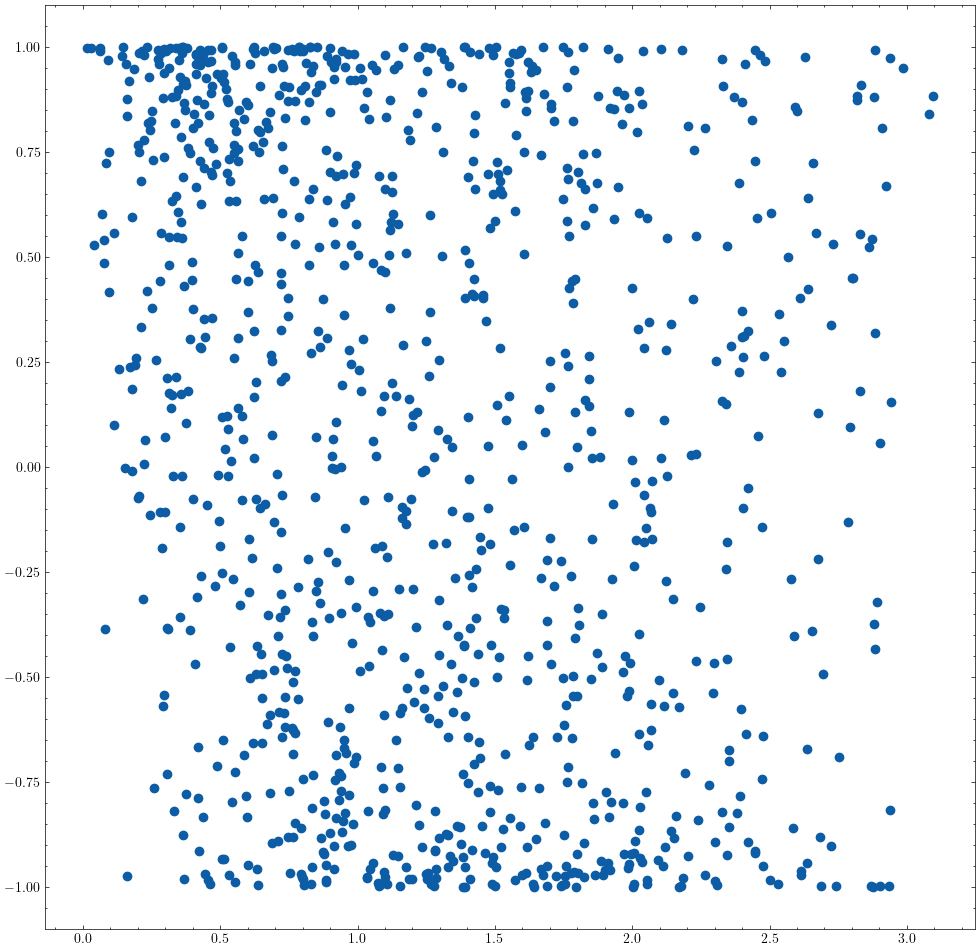

In [7]:
#Sort it by angle
x = outputs[:,0]
y = outputs[:,1]

idx = np.argsort(x)

x_sorted = x[idx]
y_sorted = y[idx]

#Plot it
import matplotlib.pyplot as plt 
import scienceplots 

plt.style.use('science')


h,w = 12,12
rows = 1
cols = 1
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)
ax.scatter(x_sorted,y_sorted)


# More GW sources


That was just with 1 GW source.

What if we have $K$ of them?

In [143]:

from scipy.stats import pearsonr

def pipeline(k,seed):

    h = None 
    measurement_noise = 0.0
    process_noise = 0.0


    f_measured,q,Npsr = create_synthetic_data(h,process_noise,measurement_noise,seed,K=k)

    outputs = np.zeros((len(indexes),2))
    print("Getting the correlations between ", len(indexes), " pairs")
    for i, (a,b) in enumerate(indexes):

        data_a = f_measured[:,a]
        data_b = f_measured[:,b]
        correlation = pearsonr(data_a, data_b).statistic 

        qa = q[a,:]
        qb = q[b,:]
        cos_angle = np.dot(qa,qb) / (np.linalg.norm(qa) * np.linalg.norm(qb))
        
        outputs[i,0] = np.arccos(cos_angle)
        outputs[i,1] = correlation


    #Sort it by angle
    x = outputs[:,0]
    y = outputs[:,1]

    idx = np.argsort(x)

    x_sorted = x[idx]
    y_sorted = y[idx]

    return x,y 








from scipy.stats import binned_statistic
def add_to_plot(x,y,ax,k,plot_datapoints=True,savefig = None):
    statistic,bin_edges,bin_number = binned_statistic(x, y,statistic='mean',bins = 15)
    statistic_sigma,bin_edges,bin_number = binned_statistic(x, y,statistic='std',bins = 15)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


    if plot_datapoints:
        ax.scatter(x,y,alpha=0.5,label = 'raw data')



    #ax.errorbar(bin_centers, statistic, yerr=statistic_sigma, fmt='o',label='binned data',c='r',s=100,marker = '^')


    ax.errorbar(bin_centers, statistic, yerr = statistic_sigma, ls = "None", color = "r",capsize=5,elinewidth=2)
    ax.scatter(bin_centers,statistic,label='binned data',c='r',s=100,marker = '^')







    ax.axhline(0.0, c='0.5', linestyle = '--')



    #config
    fs = 20
    ax.set_xlabel('Angular separation between pulsars [rad]', fontsize=fs)
    ax.set_ylabel(r'Pearson correlation', fontsize=fs)
    ax.yaxis.set_tick_params(labelsize=fs-6)
    ax.xaxis.set_tick_params(labelsize=fs-6)

    ax.set_title(f'Number of GW sources = {k}', fontsize=fs)
    ax.set_ylim(-1,1)


    if savefig is not None:
        plt.savefig(f"../data/images/HD/{savefig}.png", bbox_inches="tight",dpi=300)


    return ax




INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1237
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling
INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1238
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling


Calculating the X factor
Getting the correlations between  1081  pairs


INFO:root:You are including the PSR terms in your synthetic data generation


Calculating the X factor
Getting the correlations between  1081  pairs


INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1239
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling
INFO:root:You are including the PSR terms in your synthetic data generation


Calculating the X factor
Getting the correlations between  1081  pairs


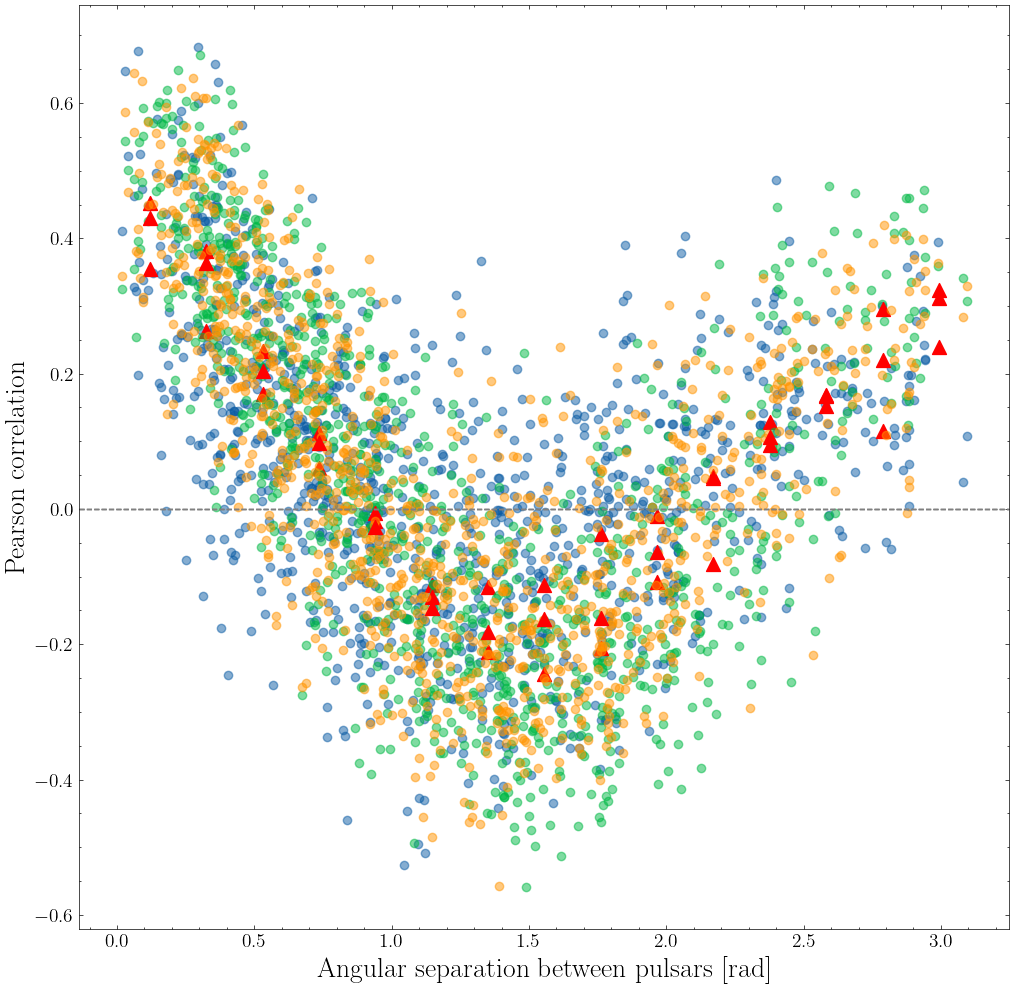

In [82]:





#Plot it
import matplotlib.pyplot as plt 
import scienceplots 

plt.style.use('science')


h,w = 12,12
rows = 1
cols = 1
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)


x,y = pipeline(100,1237)
ax = add_to_plot(x,y,ax)

x,y = pipeline(100,1238)
ax = add_to_plot(x,y,ax)



x,y = pipeline(100,1239)
ax = add_to_plot(x,y,ax)



fs = 20
ax.set_xlabel('Angular separation between pulsars [rad]', fontsize=fs)
ax.set_ylabel(r'Pearson correlation', fontsize=fs)
ax.yaxis.set_tick_params(labelsize=fs-6)
ax.xaxis.set_tick_params(labelsize=fs-6)




INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1238
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling


Running with 10 GW sources 


INFO:root:You are including the PSR terms in your synthetic data generation


Calculating the X factor
Getting the correlations between  1081  pairs


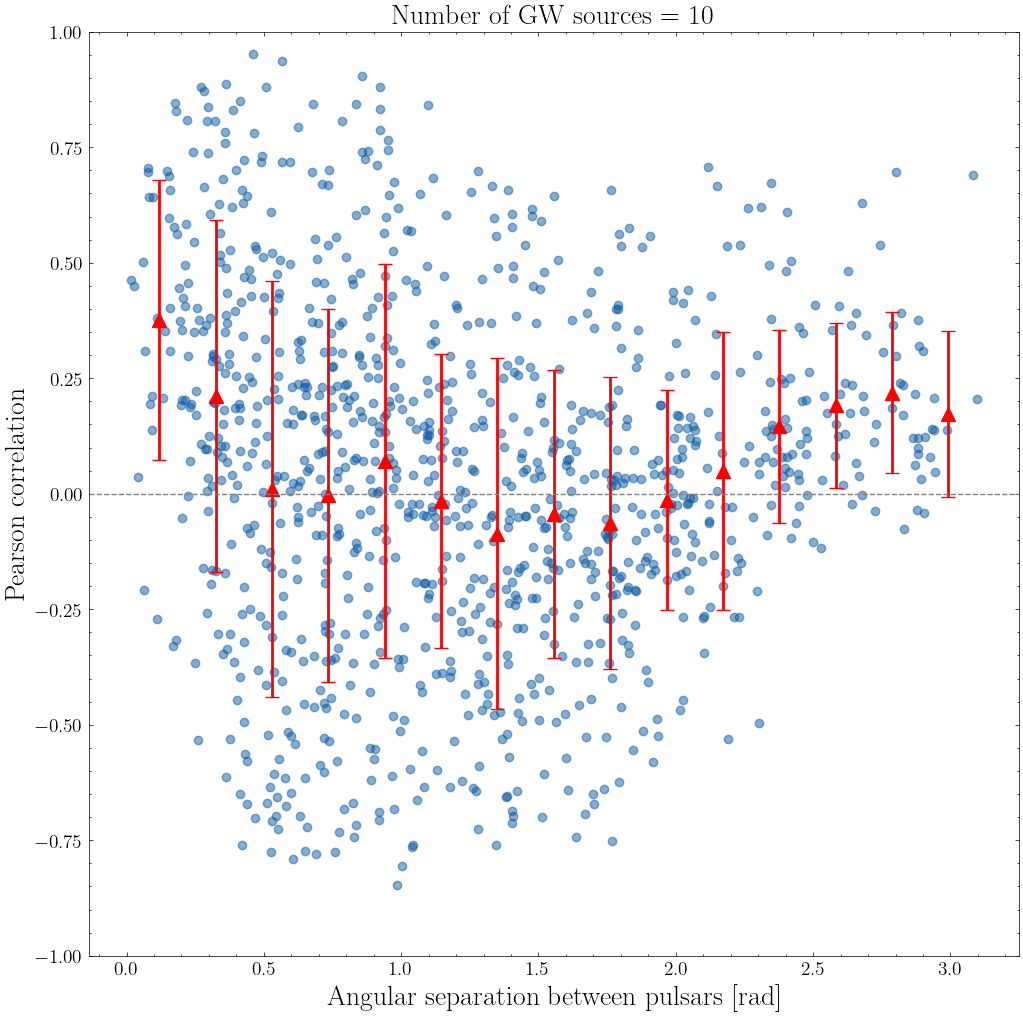

In [144]:





#Plot it
import matplotlib.pyplot as plt 
import scienceplots 

plt.style.use('science')



k=int(10)
h,w = 12,12
rows = 1
cols = 1
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)

x,y = pipeline(k,1238)
ax = add_to_plot(x,y,ax,k)








INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1238
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling
INFO:root:You are including the PSR terms in your synthetic data generation


Running with 1 GW sources 
Calculating the X factor
Getting the correlations between  1081  pairs


INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1238
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling


Running with 3 GW sources 


INFO:root:You are including the PSR terms in your synthetic data generation


Calculating the X factor
Getting the correlations between  1081  pairs


INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1238
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling
INFO:root:You are including the PSR terms in your synthetic data generation


Running with 10 GW sources 
Calculating the X factor
Getting the correlations between  1081  pairs


INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1238
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling
INFO:root:You are including the PSR terms in your synthetic data generation


Running with 31 GW sources 
Calculating the X factor
Getting the correlations between  1081  pairs


INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1238
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling
INFO:root:You are including the PSR terms in your synthetic data generation


Running with 100 GW sources 
Calculating the X factor
Getting the correlations between  1081  pairs


INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1238
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling
INFO:root:You are including the PSR terms in your synthetic data generation


Running with 316 GW sources 
Calculating the X factor
Getting the correlations between  1081  pairs


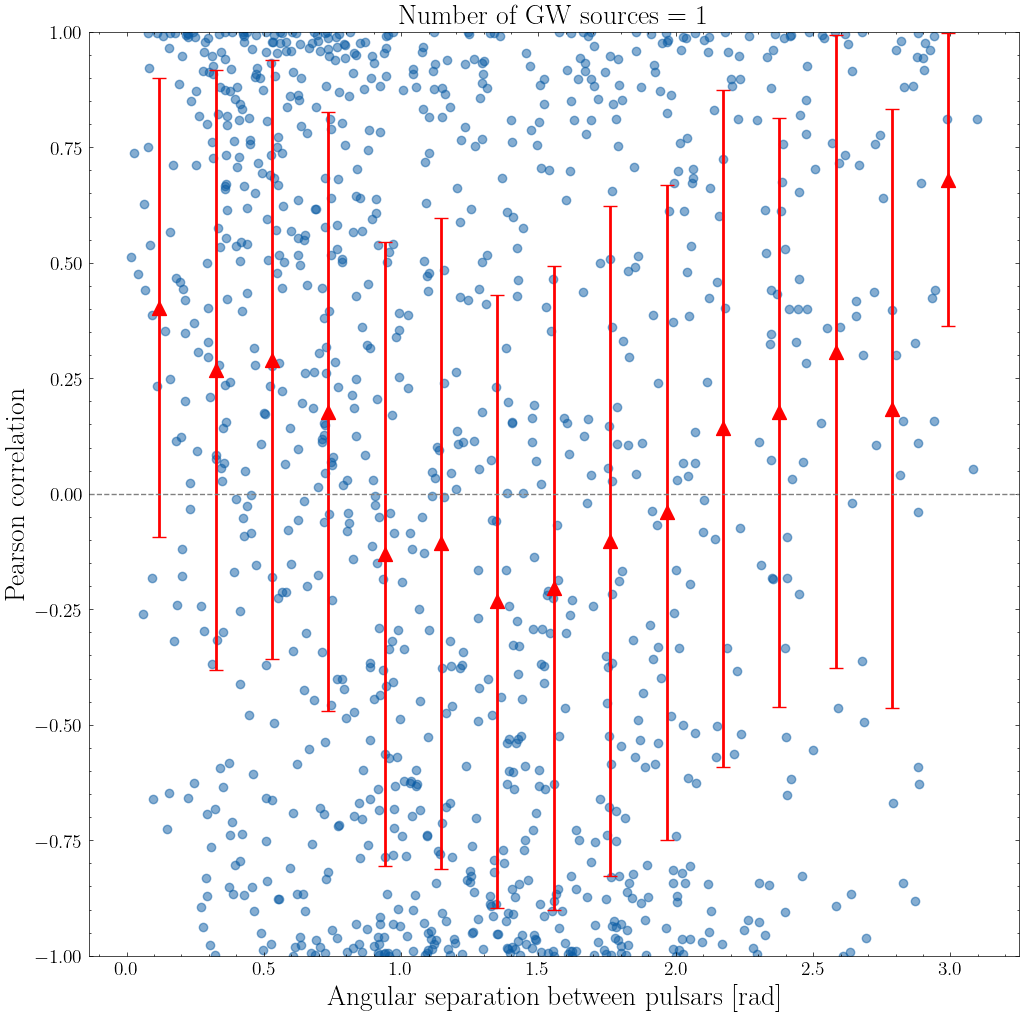

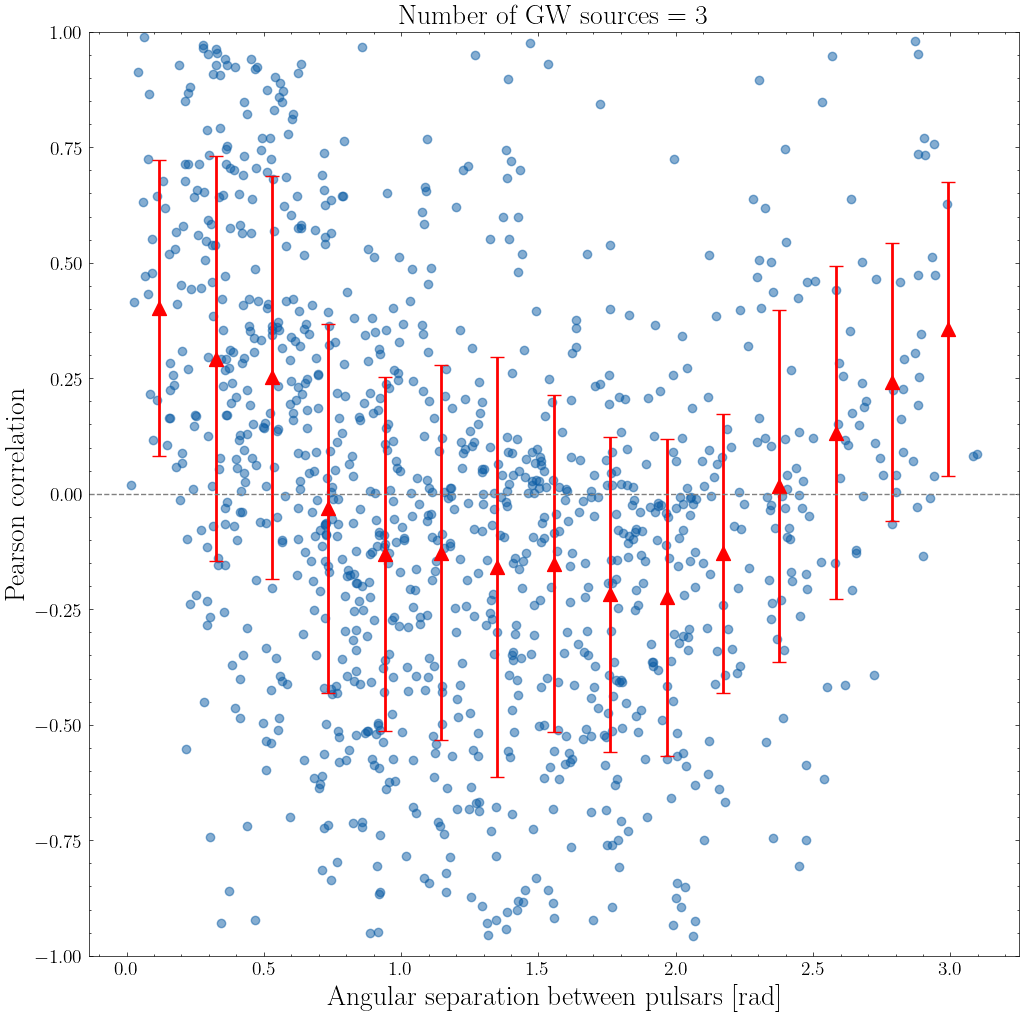

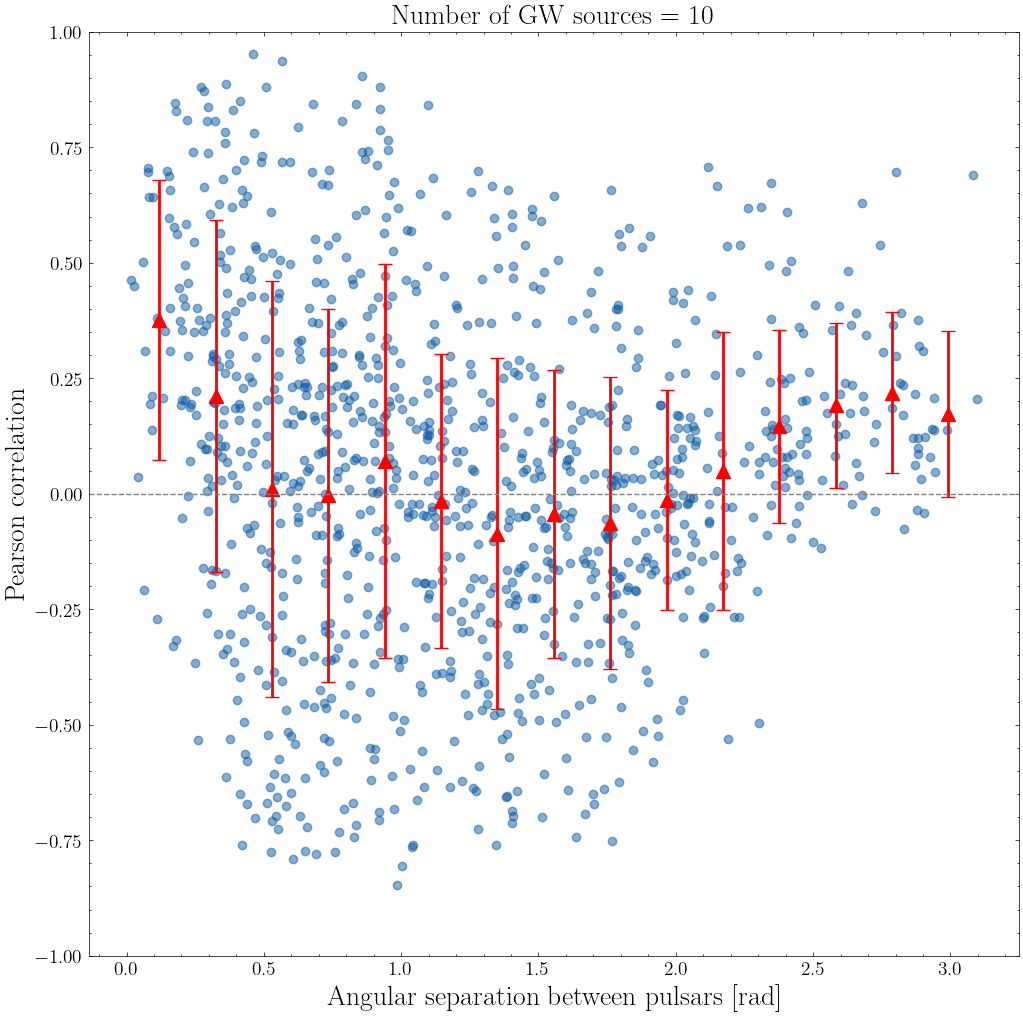

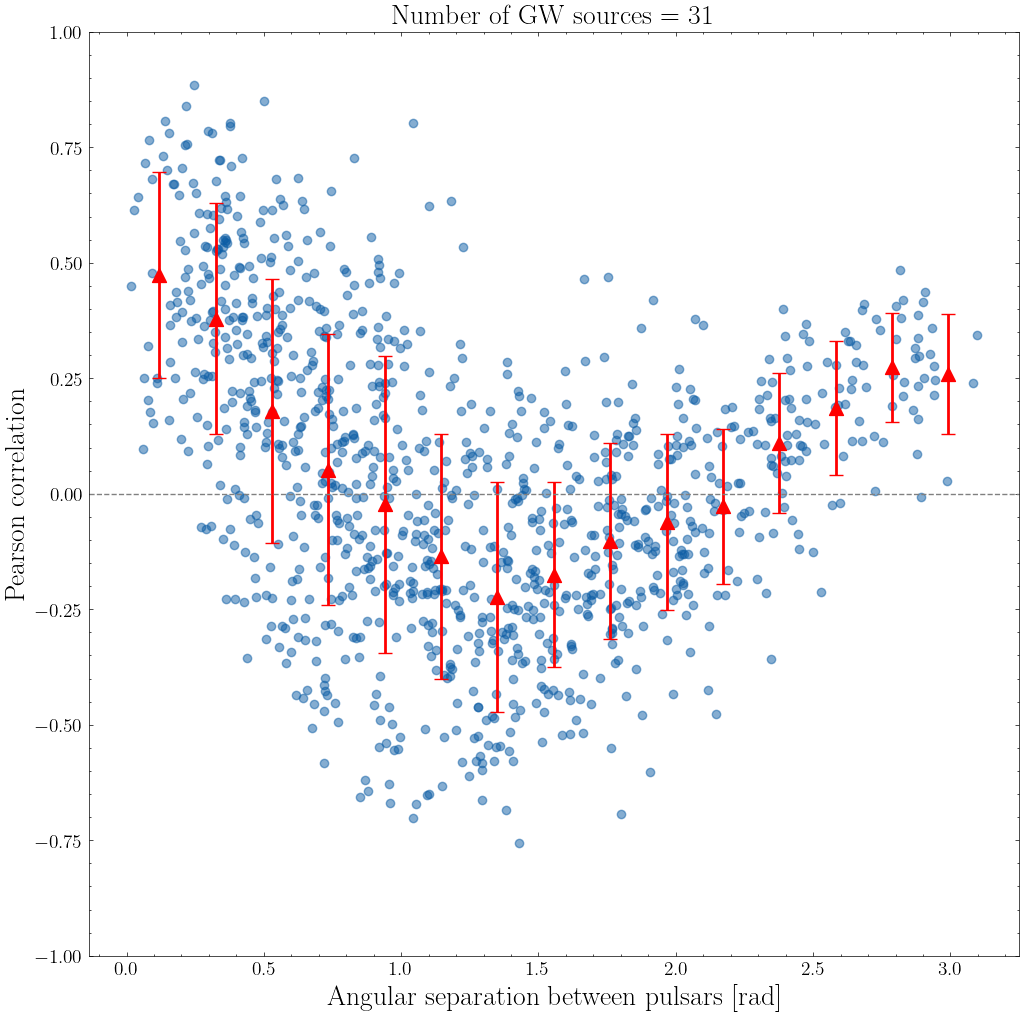

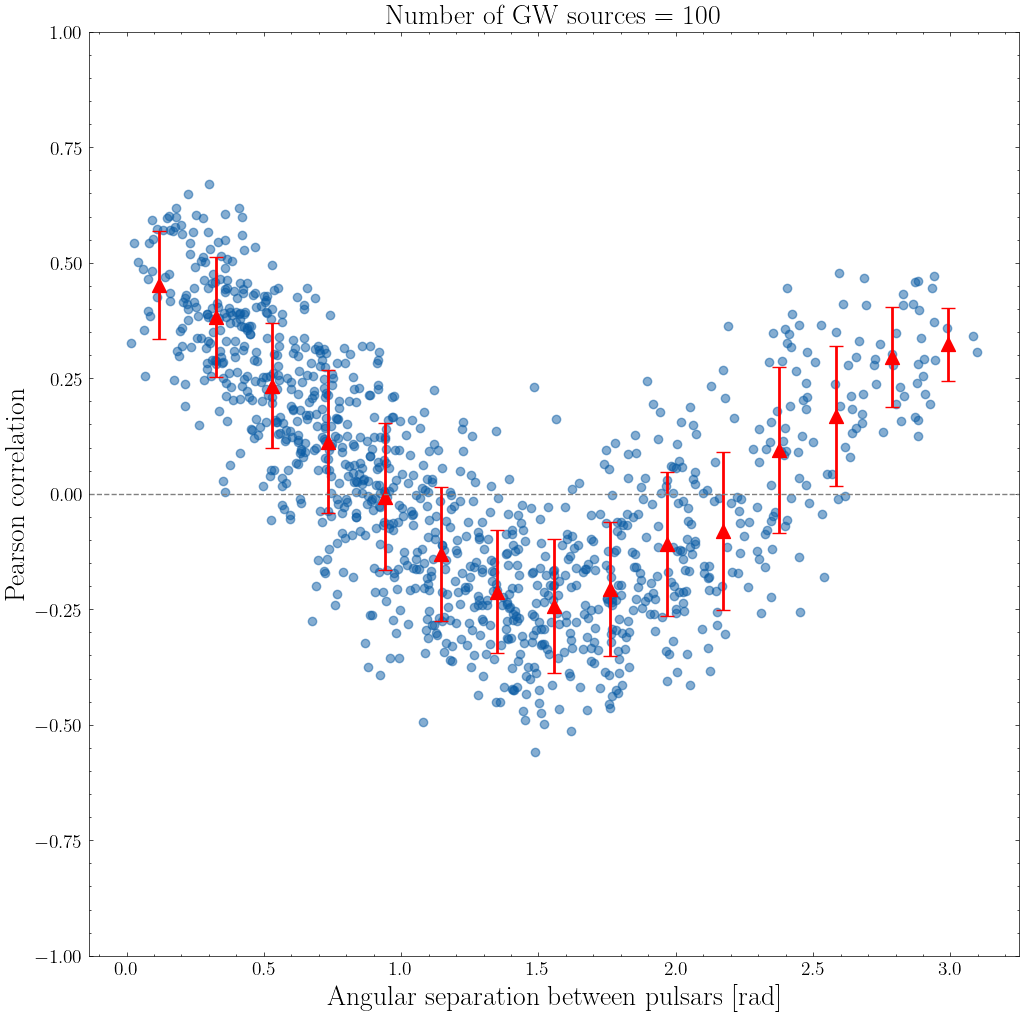

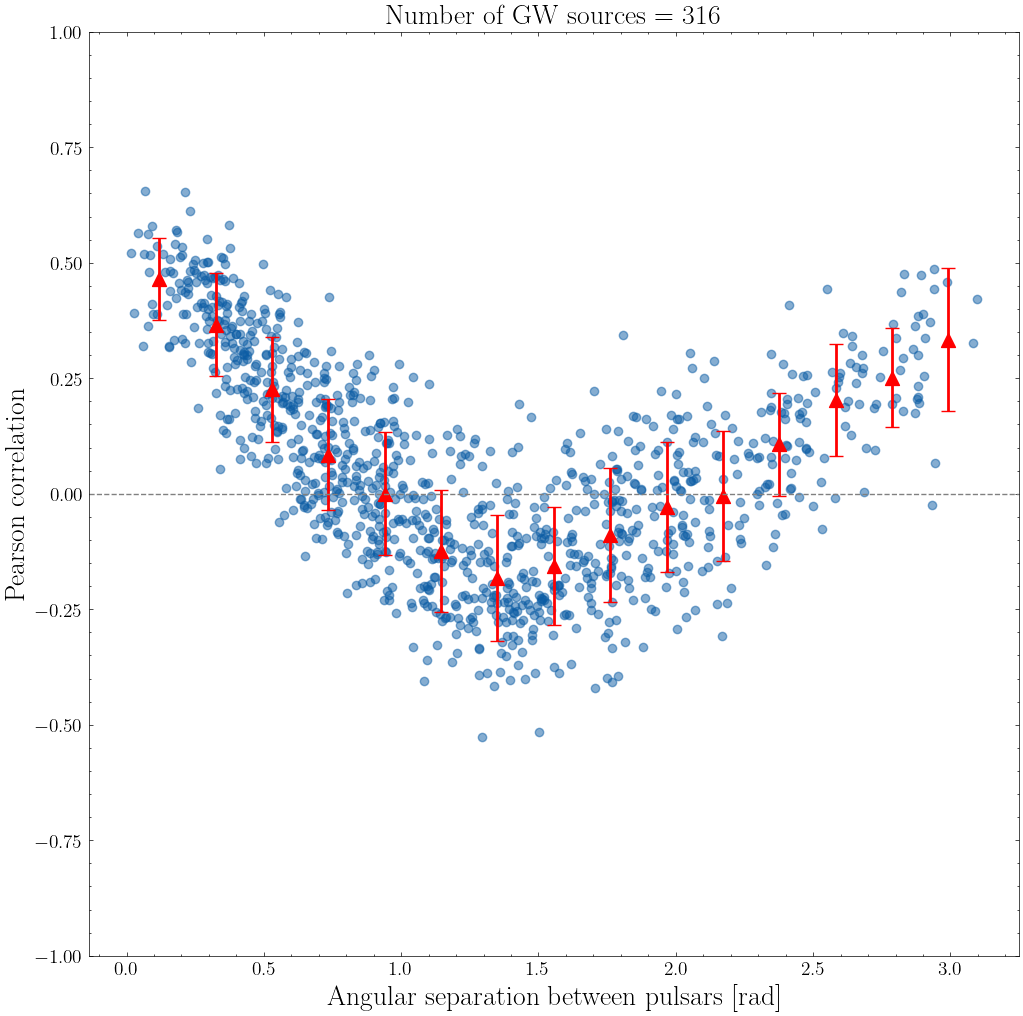

In [145]:





#Plot it
import matplotlib.pyplot as plt 
import scienceplots 

plt.style.use('science')



for k_exponent in np.arange(0,3,0.5):
    k = int(10**k_exponent)
    h,w = 12,12
    rows = 1
    cols = 1
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)

    x,y = pipeline(k,1238)
    ax = add_to_plot(x,y,ax,k,savefig=f'HD_{k}')






